In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import random
import math

import os
import torch.nn as nn
import torch.nn.functional as F

In [2]:

#data_PATH = "/content/data/"
#log_PATH = os.path.join("/gdrive","My Drive","notebooks", "logs","wgan-gp")
#modelName = "WGAN-gp_DCGAN_without_ln_conference_lsun"

batch_size =64
workers = 2
epochs = 200

latent_size=100

gf_dim = 64
df_dim = 64

in_h = 128
in_w = 128
c_dim = 1

n_critic = 5 # the number of iterations of the critic per generator iteration

learning_rate = 0.0001
beta1=0.5
beta2=0.9

gp_lambda = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

manualSeed = 3734
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

def conv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,bias=False),
        nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
    )
def tconv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,bias=False),
      nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
  )
def tconv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def conv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def fc_layer(in_features,out_features):
  return nn.Linear(in_features,out_features)

def fc_bn_layer(in_features,out_features):
  return nn.Sequential(
      nn.Linear(in_features,out_features,bias=False),
      nn.BatchNorm1d(out_features)
  )

def conv_out_size_same(size, stride):
  return int(math.ceil(float(size) / float(stride)))
s_h, s_w = in_h, in_w
s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)
s_h32, s_w32 = conv_out_size_same(s_h16, 2), conv_out_size_same(s_w16, 2)
print(s_h32, s_w32)


print(s_h16, s_w16)
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.fc_bn_layer1 = fc_bn_layer(latent_size, s_h32*s_w32*gf_dim*8) # Initial fully connected layer 100 -> 8192
        self.up_sample_layer2 = tconv_bn_layer(gf_dim*8, gf_dim*4, 4, stride=2, padding=1) # Upsample to 16x16
        self.up_sample_layer3 = tconv_bn_layer(gf_dim*4, gf_dim*2, 4, stride=2, padding=1) # Upsample to 32x32
        self.up_sample_layer4 = tconv_bn_layer(gf_dim*2, gf_dim, 4, stride=2, padding=1)   # Upsample to 64x64
        self.up_sample_layer5 = tconv_bn_layer(gf_dim, gf_dim//2, 4, stride=2, padding=1)  # Upsample to 128x128
        self.up_sample_layer6 = tconv_layer(gf_dim//2, c_dim, 4, stride=2, padding=1)      # Final convolutional layer
        ## 
        self.tanh = nn.Tanh()
        self.gaussian_kernel = nn.Parameter(torch.randn(gf_dim * 8, gf_dim * 8, 3, 3))  # Corrected input channels

        ## channels 
        self.adjust_channels2 = nn.Conv2d(gf_dim * 8, gf_dim * 4, kernel_size=1)
        self.adjust_channels3 = nn.Conv2d(gf_dim * 4, gf_dim * 2, kernel_size=1)
        self.adjust_channels4 = nn.Conv2d(gf_dim * 2, gf_dim, kernel_size=1)
        self.adjust_channels5 = nn.Conv2d(gf_dim, gf_dim // 2, kernel_size=1)
        self.adjust_channels6 =  nn.Conv2d(gf_dim // 2, c_dim, kernel_size=1)

        ## 
        self.ac3 = nn.Conv2d(gf_dim*8,gf_dim*2,kernel_size=1)
        ## 
        self.ac4 = nn.Conv2d(gf_dim*4, gf_dim, kernel_size=1)
        self.ac5 = nn.Conv2d(gf_dim * 2, gf_dim // 2, kernel_size=1)
        self.ac6 = nn.Conv2d(gf_dim,1,1)

    def forward(self, x):
        x1 = self.fc_bn_layer1(x).view(-1, gf_dim * 8, s_h32, s_w32) # Reshape after fully connected layer
        x1 = F.conv2d(x1, self.gaussian_kernel, padding=1) # 4x4
        x2 = F.relu(self.up_sample_layer2(x1)) # 8x8
        x3 = F.relu(self.up_sample_layer3(x2)) # 16x16
        x4 = F.relu(self.up_sample_layer4(x3))  # 32x32
        x5 = F.relu(self.up_sample_layer5(x4)) #64x64
        x6 = F.relu(self.up_sample_layer6(x5)) # Upsample to 128x128

        ## 
        
        x2_skip = F.interpolate(x1, scale_factor = 2, mode='nearest')
        x2_skip = self.adjust_channels2(x2_skip)
        x2 = torch.add(x2,x2_skip)
        
    #   64, 128, 16, 16
        #x3_random_noise = self.softplus(torch.randn(x3.size(),device=device))
        x3_skip = F.interpolate(x2, scale_factor = 2, mode='nearest')
        x3_skip = self.adjust_channels3(x3_skip)

        x3_skip2 = F.interpolate(x1, scale_factor = 4, mode='nearest')
        x3_skip2 = self.ac3(x3_skip2)
    
        #x3_skip2 = self.adjust_channels2(x3_skip2)
        
        x3 = torch.add(x3,x3_skip)
        #print("x3_size", x3.size())
        x3 = torch.add(x3, x3_skip2)

        ## dropout x3

        x4_skip = F.interpolate(x3, scale_factor = 2, mode='nearest')
        x4_skip = self.adjust_channels4(x4_skip)
        
        x4_skip2 = F.interpolate(x2, scale_factor = 4, mode='nearest')
        ## 
        x4_skip2 = self.ac4(x4_skip2)
        x4 = torch.add(x4,x4_skip)
        x4 = torch.add(x4,x4_skip2)
        
        
        x5_skip =F.interpolate(x4, scale_factor = 2, mode='nearest')
        x5_skip = self.adjust_channels5(x5_skip)

        x5_skip2 = F.interpolate(x3, scale_factor = 4, mode='nearest')
        x5_skip2 = self.ac5(x5_skip2)

        x5 = torch.add(x5,x5_skip)
        x5 = torch.add(x5, x5_skip2)

        x6_skip =F.interpolate(x5, scale_factor = 2, mode='nearest')
        x6_skip = self.adjust_channels6(x6_skip)

        x6_skip2 = F.interpolate(x4, scale_factor = 4, mode='nearest')
        x6_skip2 = self.ac6(x6_skip2)

        x6 = torch.add(x6,x6_skip)  
        x6 = torch.add(x6, x6_skip2)

      
        return self.tanh(x6)


Random Seed:  3734
4 4
8 8


In [3]:
from scipy.stats import truncnorm
from scipy.ndimage import gaussian_filter

def get_truncated_noise(n_samples, z_dim, truncation,device):
    '''
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
        sigma: the strength of blurring
    '''
    #### START CODE HERE ####
    truncated_noise = truncnorm.rvs(-truncation, truncation, size=(n_samples, z_dim))
    #blurred_np = gaussian_filter(truncated_noise, sigma=0.1)
    #### END CODE HERE ####
    return torch.Tensor(truncated_noise)

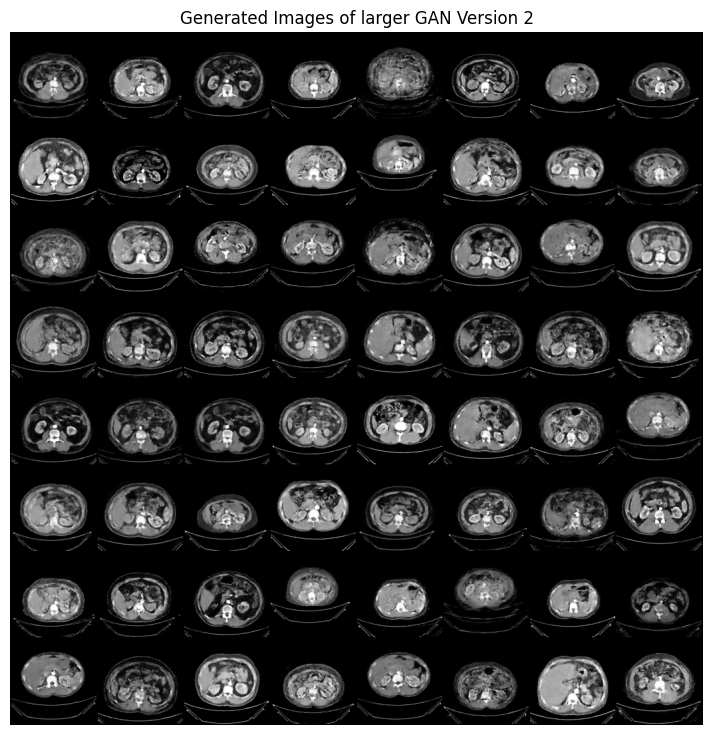

In [5]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models

# Assuming your generator model has the same architecture as 'Generator' class
  # Import your Generator class

#generator = Generator()  # Initialize your generator
generator = torch.load('../wgan_128v2/genv2-kernel-4000.pth', map_location=torch.device('cuda'))
generator.eval()  # Set the model to evaluation mode if needed
generator.cuda()

# Generate a batch of fake images
batch_size = 64
z_dim = 100  # Assuming the dimension of the input noise vector
fixed_noise = torch.randn(batch_size, z_dim,device='cuda')  #get_truncated_noise(batch_size, z_dim, 0.01, device='device').to(device)#torch.randn(batch_size, z_dim,device='cuda')  # Generate fixed noise
with torch.no_grad():
    fake_images = generator(fixed_noise).cpu()

# Plot the fake images
plt.figure(figsize=(9, 9))
plt.axis("off")
plt.title("Generated Images of larger GAN Version 2")
plt.imshow(
    np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0))
)
plt.show()


In [6]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

c:\Users\Artur\anaconda3\envs\lighthouse\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Artur\anaconda3\envs\lighthouse\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Artur\anaconda3\envs\lighthouse\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [7]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: inception_model.fc

# You want to replace the final fully-connected (fc) layer 
# with an identity function layer to cut off the classification
# layer and get a feature extractor
#### START CODE HERE ####
inception_model.fc = nn.Identity()
#### END CODE HERE ####
import scipy
# This is the matrix square root function you will be using
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    Parameters:
        x: a matrix
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: frechet_distance
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Function for returning the Fréchet distance between multivariate Gaussians,
    parameterized by their means and covariance matrices.
    Parameters:
        mu_x: the mean of the first Gaussian, (n_features)
        mu_y: the mean of the second Gaussian, (n_features) 
        sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
        sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
    '''
    #### START CODE HERE ####
    return torch.norm(mu_x - mu_y, p = 2)**2 + torch.trace(sigma_x + sigma_y - 2*matrix_sqrt(sigma_x@sigma_y))
    #### END CODE HERE ####

import numpy as np
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(64, 64)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.image_filenames = [filename for filename in os.listdir(root_dir) if filename.endswith('.png')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_filenames[idx])
        image = Image.open(img_name)
        #image = image.resize(self.target_size, Image.LANCZOS)  # Resize image with LANCZOS filter
        if self.transform:
            image = self.transform(image)
        return image


# Define constants
IMAGE_SIZE = (64, 64)
IMAGE_DIR = '../experimental'

print(in_h,in_w)
# Transformation to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((in_h,in_w)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Create dataset
dataset = CustomDataset(root_dir=IMAGE_DIR, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)
# Function to convert grayscale images to RGB
def convert_to_rgb(grayscale_images):
    return torch.cat([grayscale_images] * 3, dim=1)  #



128 128


In [14]:
3274 / batch_size

51.15625

In [8]:
from tqdm.auto import tqdm

fake_features_list = []
real_features_list = []

generator.eval()

n_samples = 3274


cur_samples = 0


# Function to resize images to the minimum required size for Inception model
def resize_to_min_size(images, min_size=(299, 299)):
    return F.interpolate(images, size=min_size, mode='bicubic', align_corners=False)

with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
    for real_example in tqdm(dataloader, total=n_samples // batch_size): # Go by batch
        #print()
        real_samples = real_example
        real_samples_rgb = convert_to_rgb(real_samples)
        real_samples_resized = resize_to_min_size(real_samples_rgb)  # Resize to minimum required size
        real_features = inception_model(real_samples_resized.to(device)).detach().to('cpu') # Move features to CPU
        real_features_list.append(real_features)

        fake_samples = get_noise(len(real_example), z_dim).to(device)
        
        fake_samples = preprocess(generator(fake_samples))
        #print(fake_samples.shape)
        fake_samples_rgb = convert_to_rgb(fake_samples)  # Convert fake samples to RGB
        fake_samples_resized = resize_to_min_size(fake_samples_rgb)  # Resize to minimum required size
        fake_features = inception_model(fake_samples_resized.to(device)).detach().to('cpu') # [64,2048]
        fake_features_list.append(fake_features)
        #print(fake_features.shape)
        cur_samples += len(real_samples)
        if cur_samples > n_samples:
            break   

# Function to convert grayscale images to RGB
def convert_to_rgb(grayscale_images):
    # Replicate single channel to create three channels
    return grayscale_images.repeat(1, 3, 1, 1)



c:\Users\Artur\anaconda3\envs\lighthouse\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/51 [00:00<?, ?it/s]

52it [00:59,  1.15s/it]                        


In [9]:
from torch.distributions import MultivariateNormal
import seaborn as sns # This is for visualization
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# UNIT TEST COMMENT: Needed as is for autograding

print(len(fake_features_list))
print(fake_features_list[0].shape)

## 
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

print(fake_features_all.shape)
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL

# Calculate the covariance matrix for the fake and real features
# and also calculate the means of the feature over the batch (for each feature dimension mean)
#### START CODE HERE ####
mu_fake = torch.mean(fake_features_all, dim=0)
mu_real = torch.mean(real_features_all, dim=0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)
#### END CODE HERE ####

52
torch.Size([64, 2048])
torch.Size([3274, 2048])


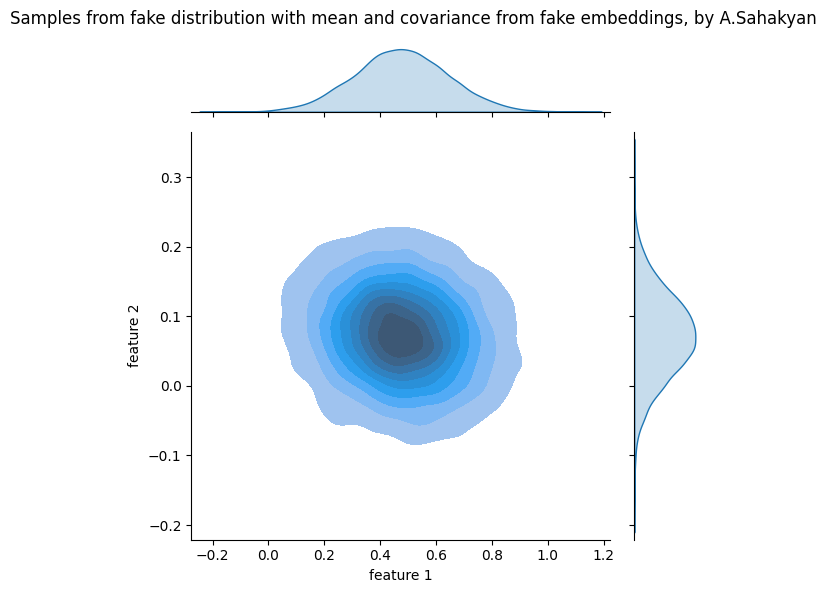

In [16]:
## LEVEL CURVES FOR FAKE VARIANCE
fake_dist = MultivariateNormal(mu_fake, sigma_fake)
fake_samples = fake_dist.sample((10000,))
fakeplot = sns.jointplot(x=fake_samples[:, 0], y=fake_samples[:, 1], kind="kde", fill=True)
fakeplot.set_axis_labels("feature 1", "feature 2") 

plt.suptitle("Samples from fake distribution with mean and covariance from fake embeddings, by A.Sahakyan")
plt.tight_layout()
plt.show()

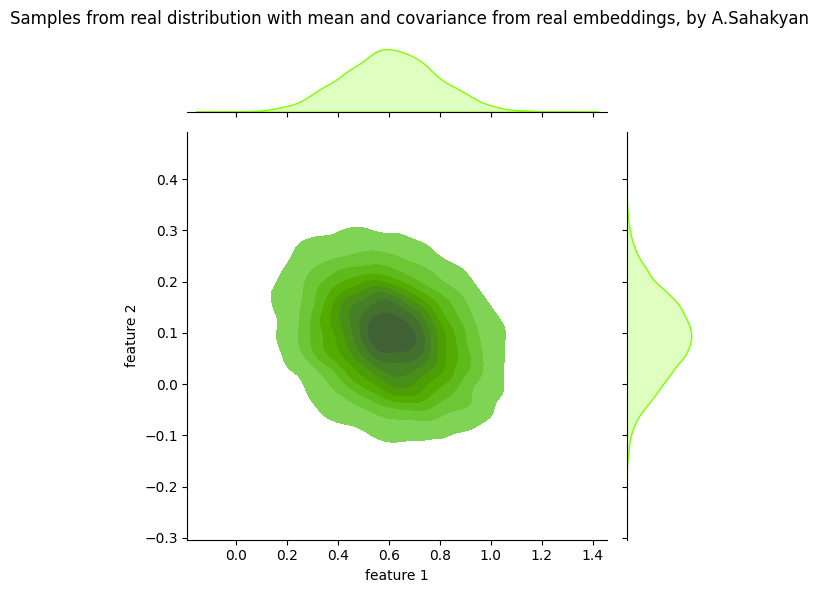

In [17]:
real_dist = MultivariateNormal(mu_real, sigma_real)
real_samples = real_dist.sample((10000,))
realplot = sns.jointplot(x=real_samples[:, 0], y=real_samples[:, 1], kind="kde",color='chartreuse', fill=True)
realplot.set_axis_labels("feature 1", "feature 2") 
plt.suptitle("Samples from real distribution with mean and covariance from real embeddings, by A.Sahakyan")
plt.tight_layout()
plt.show()

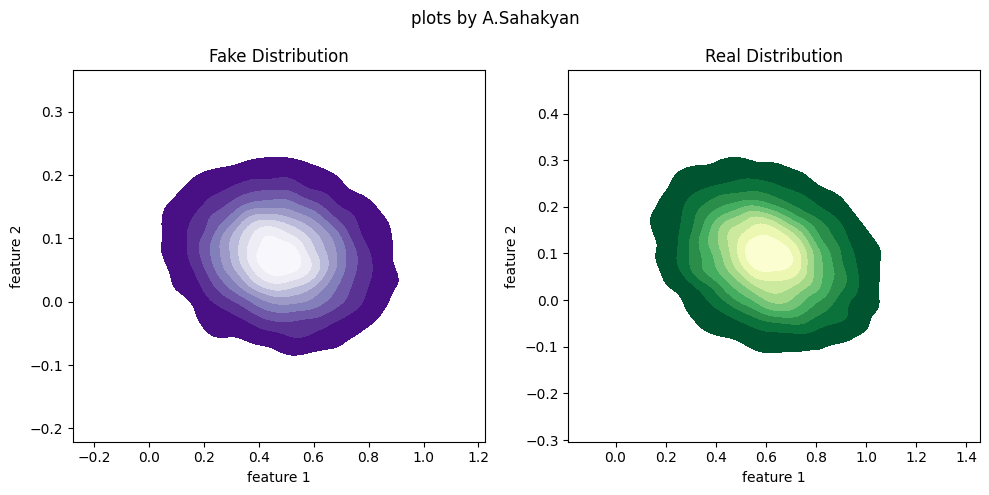

In [18]:
# Create joint plots with shaded level curves and labeled axes
#fakeplot = sns.jointplot(x=fake_samples[:, 0], y=fake_samples[:, 1], kind="kde", shade=True, color="b", alpha=0.5)
#realplot = sns.jointplot(x=real_samples[:, 0], y=real_samples[:, 1], kind="kde", shade=True, color="orange", alpha=0.5)

# Overlay the plots
plt.figure(figsize=(10, 5))
plt.subplot(121)  # Fake distribution
sns.kdeplot(x=fake_samples[:, 0], y=fake_samples[:, 1], cmap="Purples_r", fill=True, alpha=1)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title("Fake Distribution")
plt.subplot(122)  # Real distribution
sns.kdeplot(x=real_samples[:, 0], y=real_samples[:, 1], cmap="YlGn_r", fill=True, alpha=1)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title("Real Distribution")
plt.suptitle("plots by A.Sahakyan")
plt.tight_layout()
plt.show()

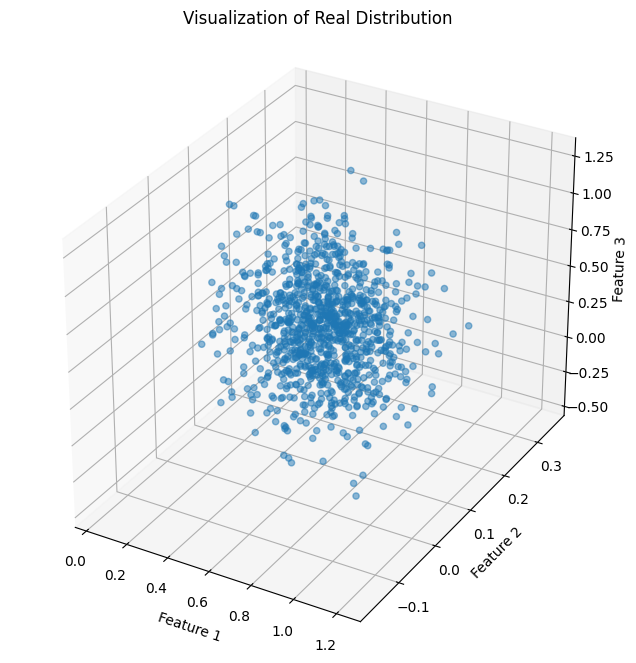

In [92]:
samples = real_dist.sample((1000,)).numpy()

# Plot a 2D slice
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the samples
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], alpha=0.5)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('Visualization of Real Distribution')

ax.set_box_aspect([1.5,2,1.5]) 

plt.show()

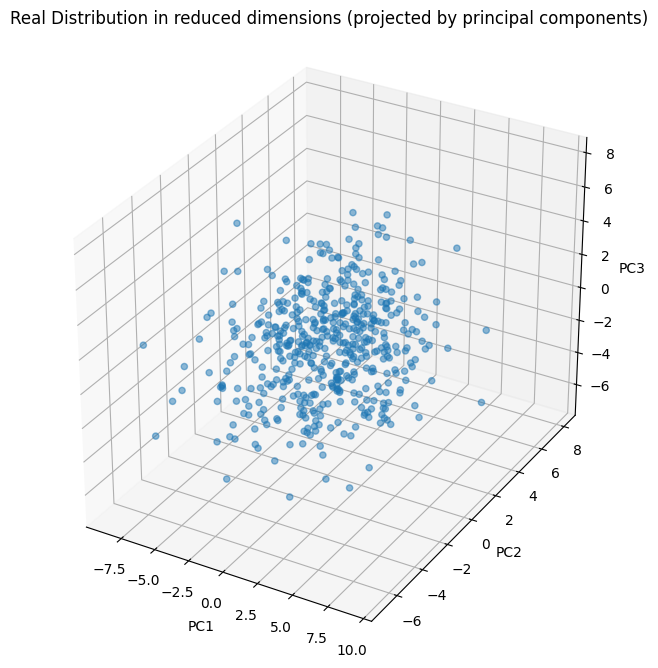

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Sample from the distribution
samples = real_dist.sample((500,)).numpy()

# Apply PCA to reduce dimensionality to 3
pca = PCA(n_components=3)
samples_pca = pca.fit_transform(samples)

# Plot 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the samples after PCA
ax.scatter(samples_pca[:, 0], samples_pca[:, 1], samples_pca[:, 2], alpha=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Real Distribution in reduced dimensions (projected by principal components)')

ax.set_box_aspect([1.5,2,1.5]) 


plt.show()

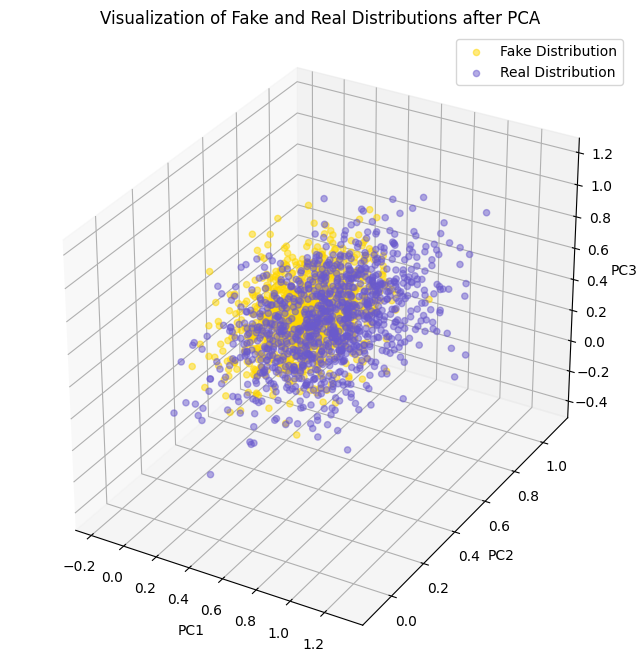

In [24]:
from sklearn.preprocessing import MinMaxScaler
#Sample from the distributionssamples_fake = fake_dist.sample((1000,)).numpy()
samples_real = real_dist.sample((1000,)).numpy()
samples_fake = fake_dist.sample((1000,)).numpy()
# Apply PCA to reduce dimensionality to 3 for both fake and real samples
pca = PCA(n_components=3)
samples_fake_pca = pca.fit_transform(samples_fake)
samples_real_pca = pca.transform(samples_real)

# Normalize the principal components to have similar scales
scaler = MinMaxScaler()
samples_fake_pca_scaled = scaler.fit_transform(samples_fake_pca)
samples_real_pca_scaled = scaler.transform(samples_real_pca)

# Plot 3D scatter plot
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the samples after PCA for fake distribution
ax.scatter(samples_fake_pca_scaled[:, 0], samples_fake_pca_scaled[:, 1], samples_fake_pca_scaled[:, 2], color='gold', alpha=0.5, label='Fake Distribution')

# Plot the samples after PCA for real distribution
ax.scatter(samples_real_pca_scaled[:, 0], samples_real_pca_scaled[:, 1], samples_real_pca_scaled[:, 2], color='slateblue', alpha=0.5, label='Real Distribution')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Visualization of Fake and Real Distributions after PCA')
ax.legend()

# Set aspect ratio to make sure all labels and data points are visible
ax.set_box_aspect([1.5,2,1.5]) 

plt.show()

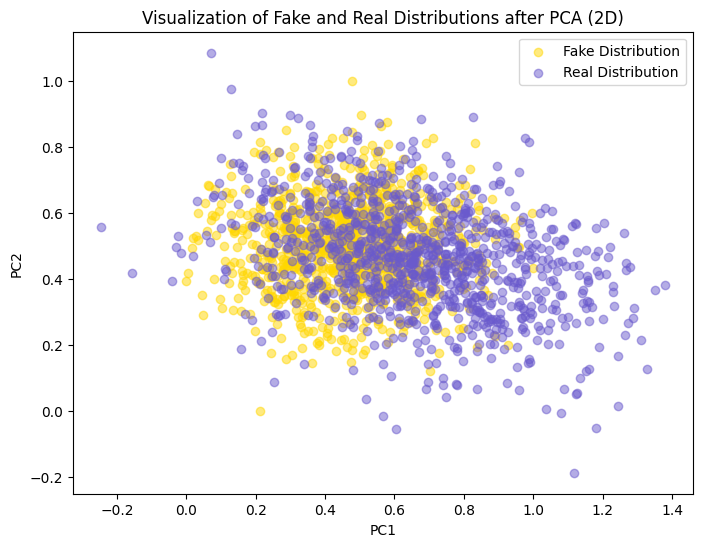

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Sample from the distributions
samples_fake = fake_dist.sample((1000,)).numpy()
samples_real = real_dist.sample((1000,)).numpy()

# Apply PCA to reduce dimensionality to 2 for both fake and real samples
pca = PCA(n_components=2)
samples_fake_pca = pca.fit_transform(samples_fake)
samples_real_pca = pca.transform(samples_real)

# Normalize the principal components to have similar scales
scaler = MinMaxScaler()
samples_fake_pca_scaled = scaler.fit_transform(samples_fake_pca)
samples_real_pca_scaled = scaler.transform(samples_real_pca)

# Plot 2D scatter plot
plt.figure(figsize=(8, 6))

# Plot the samples after PCA for fake distribution
plt.scatter(samples_fake_pca_scaled[:, 0], samples_fake_pca_scaled[:, 1], color='gold', alpha=0.5, label='Fake Distribution')

# Plot the samples after PCA for real distribution
plt.scatter(samples_real_pca_scaled[:, 0], samples_real_pca_scaled[:, 1], color='slateblue', alpha=0.5, label='Real Distribution')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of Fake and Real Distributions after PCA (2D)')
plt.legend()

plt.show()


In [26]:
real_dist

MultivariateNormal(loc: torch.Size([2048]), covariance_matrix: torch.Size([2048, 2048]))

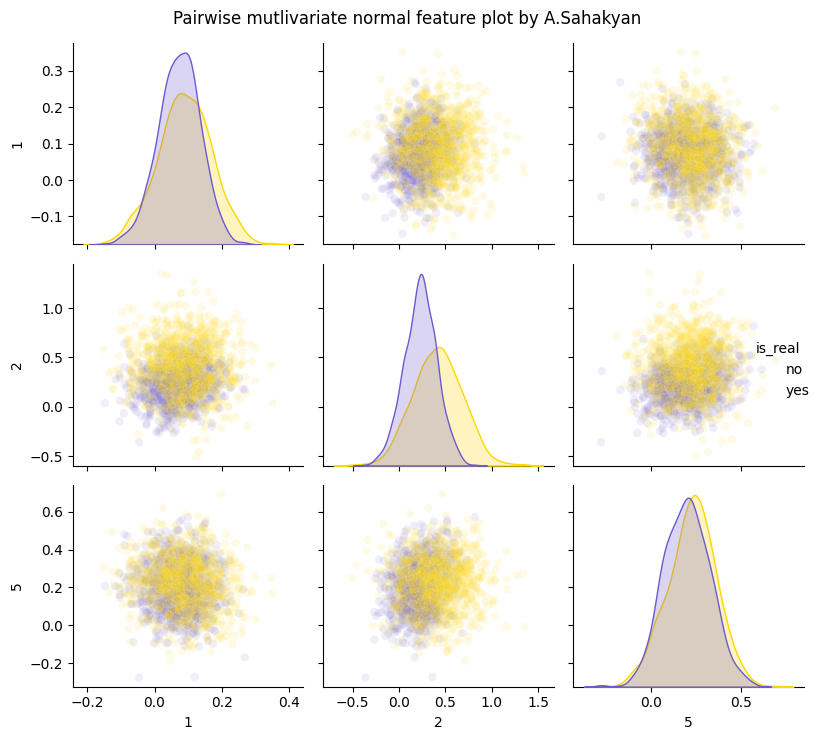

In [22]:
indices = [1,2,5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((1000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((1000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(data = df, plot_kws={'alpha': 0.1}, hue='is_real', palette={"no":"slateblue","yes":"gold"})
plt.suptitle("Pairwise mutlivariate normal feature plot by A.Sahakyan")
plt.tight_layout()
plt.show()


In [9]:
# 9000 epochs
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

90.4835205078125


In [10]:
# 4000 epochs
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

105.10450744628906


In [8]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

89.9940185546875
